## **segmentation map으로 도로 이미지 만들기**  
### **1. 데이터 준비**    
### **2. 데이터 전처리**  
### **3. Generator 구성하기(U-Net)**  
### **4. Discriminator 구성하기**  
### **5. 학습 및 테스트**  

In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import image
from tensorflow import data
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

print(np.__version__)
print(tf.__version__)

1.22.3
2.9.0


---

### **1. 데이터 준비**

In [2]:
# cd ~/aiffel/segmentation_map && unzip cityscapes.zip
# data_path = os.getenv('HOME')+'/aiffel/segmentation_map/cityscapes/train/*'
data_path = '/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/segmentation_map/cityscapes/train/'

print("number of train examples :", len(os.listdir(data_path)))


number of train examples : 1000


(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)


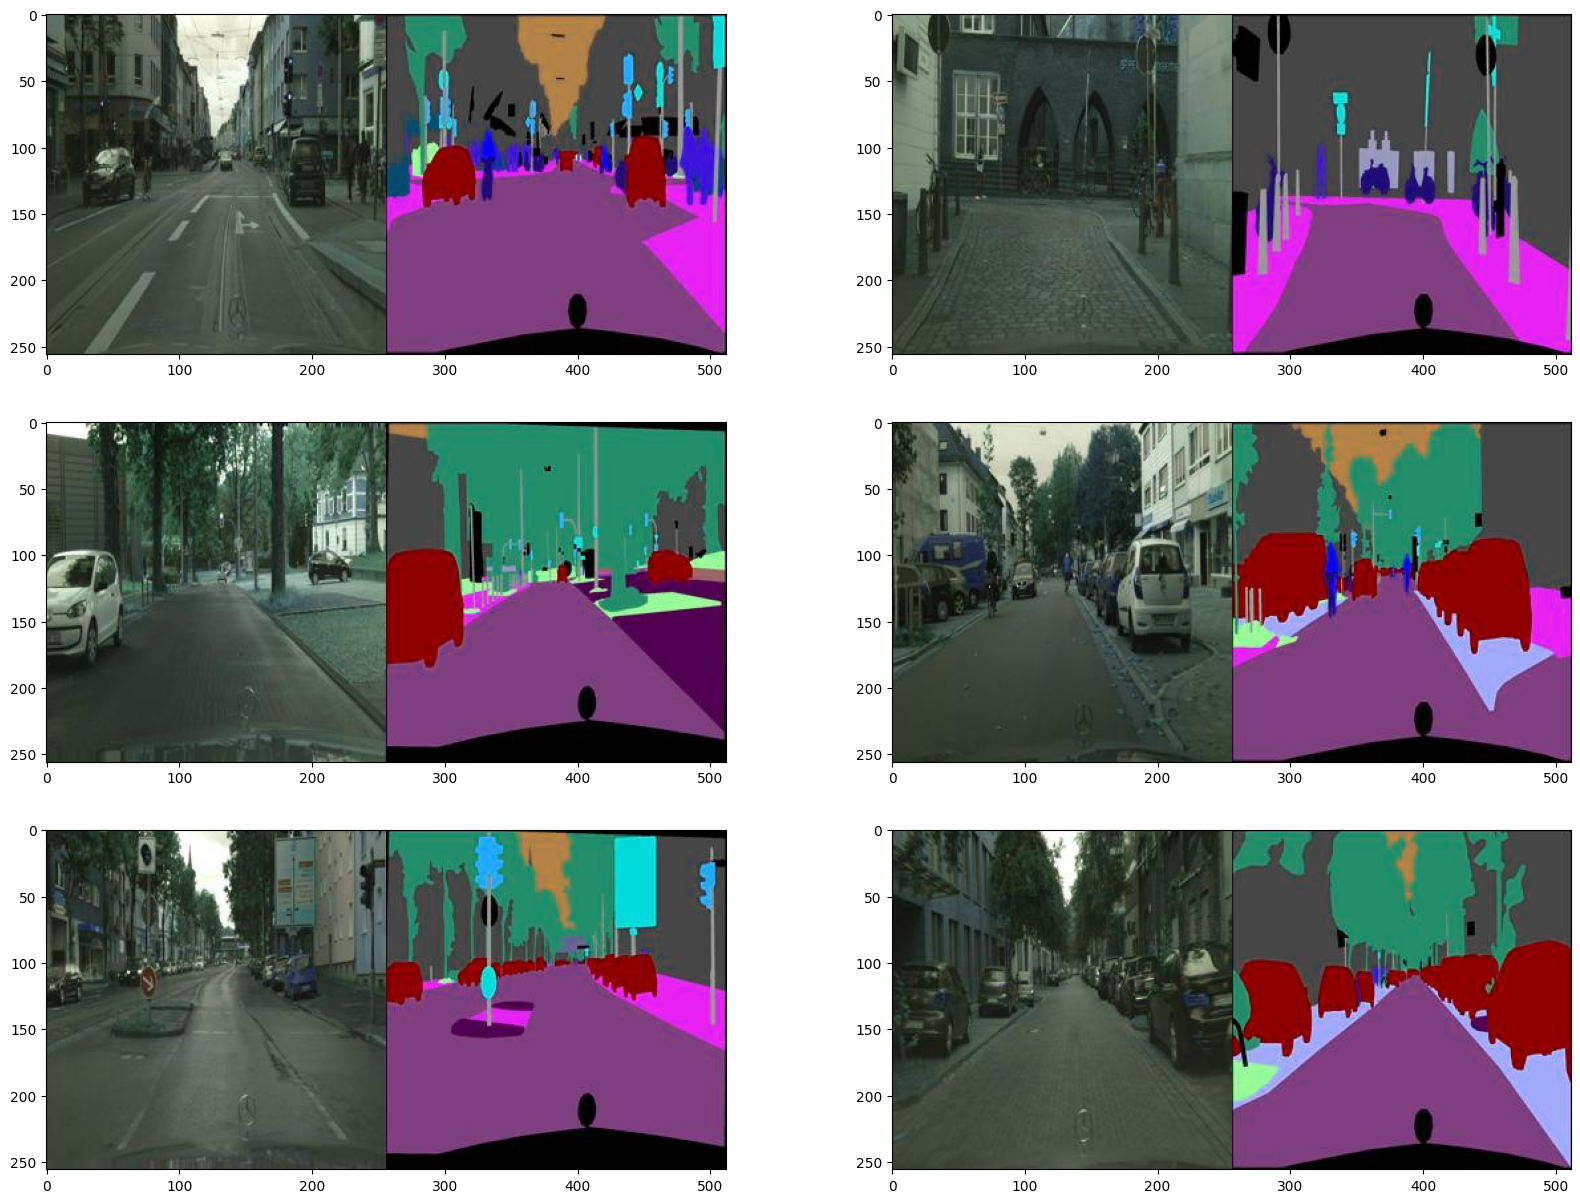

In [3]:
# 데이터 시각화 (확인)
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    print(img.shape)
    plt.subplot(3,2,i)
    plt.imshow(img)

----

### **2. 데이터 전처리**

- 각 원본 이미지는 256x256 이미지 2개가 포함된 256x512 크기

#### **2-1.이미지 분리**

In [4]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)
    
def load(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_image(image, 3)
    # image = cv2.imread(image, cv2.IMREAD_COLOR)
        
    # split : read image, fake image 
    w = tf.shape(img)[1] // 2
    fake_image = image[:,w:,:]
    real_image = image[:,:w,:]
    # tf.cast : type 변환
    fake_image = tf.cast(fake_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    # normalize
    fake_image = normalize(fake_image)
    real_image = normalize(real_image)
        
    return fake_image, real_image

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-29 13:20:28.826997: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-29 13:20:28.827113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


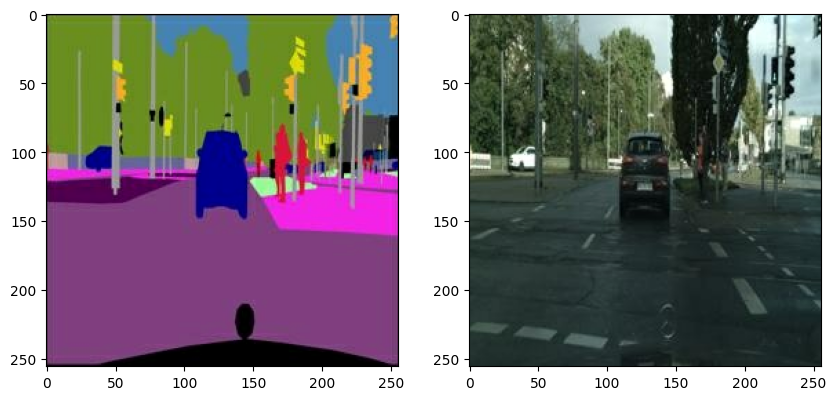

In [5]:
f = data_path + os.listdir(data_path)[1]
fake, real = load(f)

plt.figure(figsize=(10 ,10))

plt.subplot(1,2,1); plt.imshow(denormalize(fake))
plt.subplot(1,2,2); plt.imshow(denormalize(real))
    

#### **2-2. 데이터 증강**  
- 50%의 확률로 : 
  
    - Reflecting padding | Constant padding   
      
    - 가로로 뒤집기 | 세로로 뒤집기  
    - 회전

In [6]:
@tf.function() # 빠른 텐서플로 연산
# 데이터 증강 함수
def apply_augmentation(fake, real):   
    stacked = tf.concat([fake, real], axis=-1)                          # 두 이미지를 채널 축으로 연결 (각 3채널 -> 6채널)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])                         # 30 pixel의 pad width를 넣기 위함
    if tf.random.uniform(()) < .5:                                      # 50% 확률로
        padded = tf.pad(stacked, _pad, "REFLECT")                       # Reflecting padding
    else:                                                               # 또는
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)  # Constant padding

    out = image.random_crop(padded, size=[256, 256, 6])                 # (256, 256, 6) 이미지를 임의로 잘라냄
    
    if tf.random.uniform(()) < .5:  # 50%   (                           # 50% 확률로
        out = image.random_flip_left_right(out)                         # 가로로 뒤집기 
    else:                                                               # 또는
        out = image.random_flip_up_down(out)                            # 세로로 뒤집기
    
    if tf.random.uniform(()) < .5:                                      # 50%의 확률로
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)                                # 회전

    fake = out[...,:3]
    real = out[...,3:] 
                
    return fake, real

2023-05-29 13:20:29.273311: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-29 13:20:29.273751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


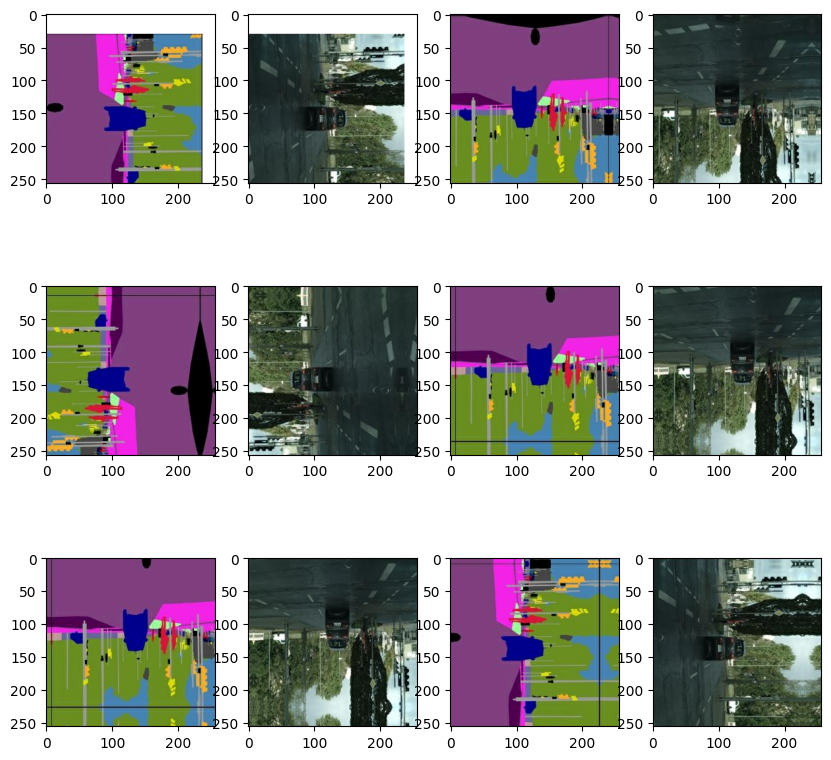

In [7]:
# 함수 적용 및 시각화
plt.figure(figsize=(10, 10))
for i in range(1, 13, 2):    
    aug_fake, aug_real = apply_augmentation(fake, real)
    
    plt.subplot(3, 4, i); plt.imshow(denormalize(aug_fake))
    plt.subplot(3, 4, i+1); plt.imshow(denormalize(aug_real))

- **[tf.data.Dataset에 대한 설명]**  
https://www.tensorflow.org/guide/data#basic_mechanics

In [8]:
# 학습 데이터 만들기
def get_train_data(img_path):
    fake, real = load(img_path)
    fake, real = apply_augmentation(fake, real)
    return fake, real

# Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on the Dataset object.
# For example, you can apply per-element transformations such as Dataset.map, and multi-element transformations such as Dataset.batch. 
# Refer to the documentation for tf.data.Dataset for a complete list of transformations.

# tf.dataset.shuffle() : transformation maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer.
# tf.dataset.batch(n) : data를 n개씩 묶음
train_images = data.Dataset.list_files(data_path + '*.jpg')
train_images = train_images.map(get_train_data).shuffle(100).batch(4)   

print(len(train_images))
print(type(train_images))
print(train_images)

250
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


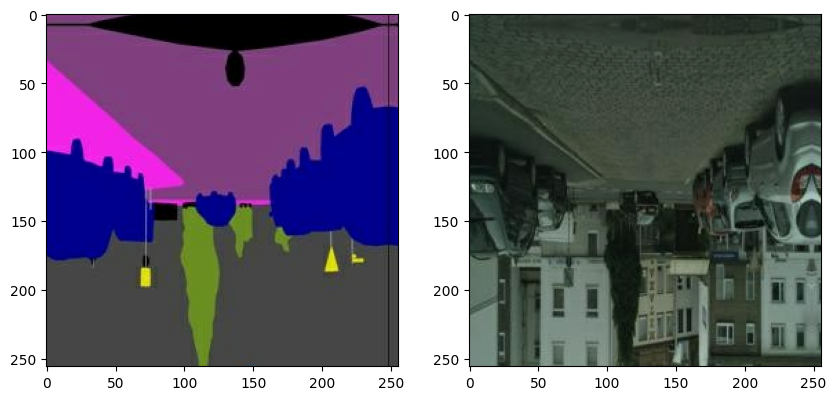

In [9]:
# 확인
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
fake, real = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,10))
plt.subplot(1,2,1); plt.imshow(fake[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real[0].astype(np.uint8))

----

### **3. Generator 구성하기(U-Net)**



![]()
<img src="https://imgur.com/8qXHsK8.png" width="400px" height="500px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>


![]()
<img src="https://imgur.com/3IVnccZ.png" width="400px" height="200px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

- **[Encode Block]**  
  
    - 'Convolution -> BatchNorm -> LeakyReLU'의 3개 레이어로 구성된 기본적인 블록을 하나의 레이어로 구성    
  


- **[Decode Block]**  
  
    - 'Convolution -> BatchNorm -> Dropout -> ReLU'의 4개 레이어로 구성된 기본적인 블록을 하나의 레이어로 구성  

- **[UNetGenerator]**  
  
    - encoder와 decoder에서 사용할 블록을 정의  
    - forward propagation *(skip connection)*

In [10]:
# Encode Block
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

# Decoder Block   
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [11]:
# U-Net Generator
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # encoder, decoder에서 사용할 블록 한번에 정의
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        # encoder
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]    # encoder의 마지막 출력은 decoder에 직접 연결됨
        # skip connection : decoder(+encoder result)            
        for block, feat in zip(self.decode_blocks, features[::-1]):     # decoder의 연산 방향과 encoder result가 반대
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [12]:
# U-Net 구조 Generator 내부 출력 확인
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

----

### **4. Discriminator 구성하기**


![]()
<img src="https://imgur.com/VQdaZZt.png" width="400px" height="500px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

- 'Convolution -> BatchNorm -> LeakyReLU'의 3개 레이어로 구성된 기본적인 블록을 하나의 레이어로 구성  

In [13]:
class DiscBlock(layers.Layer):
    # n_filter : 필터의 수
    # stride : 필터가 순회하는 간격
    # custom_pad : 출력 feature_map의 크기를 조절할 수 있도록 하는 패딩 설정
    # use_bn : BatchNorm의 사용여부
    # act : 활성화 함수 사용 여부
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

- Pix2Pix의 Discriminator : 70x70 ParchGAN 사용  
    -> 최종 출력을 (30, 30)크기로 맞춤

In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        # stride (0~2): 2; (3~4): 1
        # custom padding (0~2): False
        # Batch Normalization (0,4): False
        # activation function (0~3): LeakyReLU; (4): sigmoid
        self.blocks = [layers.Concatenate()]
        self.sigmoid = layers.Activation('sigmoid')
        for i, filter in enumerate(filters):
            self.blocks.append(DiscBlock(
                        n_filters=filter, 
                        stride=2 if i<3 else 1,
                        custom_pad=False if i<3 else True,
                        use_bn=False if i==0 and i==4 else True,
                        act=True if i<4 else False
                        ))
            
    
    def call(self, x, y):
        out = self.blocks[0]([x,y])
        for i, block in enumerate(self.blocks):
            out = self.blocks[i]([x,y] if i==0 else out)

        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [15]:
# 내부 출력 확인
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

---

### **5. 학습 및 테스트**




![]()
<img src="https://imgur.com/u0GLgqT.png" width="600px" height="400px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

- 'L1 + 일반적인 GAN 손실함수' 에서 가장 실제에 가까운 이미지를 생성  

In [16]:
# 손실 함수 정의
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# Generator의 손실 함수
# fake_output : 생성한 가짜 이미지
# real_output : 실제 이미지
# fake_disc : Generator가 생성한 가짜 이미지를 Discriminator에 입력해 얻어진 값
def get_gene_loss(fake_output, real_output, fake_disc):     
    l1_loss = mae(real_output, fake_output)                 # mae() : L1 손실을 계산하기 위해
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)     # tf.ones_like() : 실제 이미지(1)와 비교하기 위해
    return gene_loss, l1_loss

# Discriminator의 손실 함수
# fake_disc : 가짜 이미지가 Discriminator에 입력되어 얻어진 값
# real_disc : 진짜 이미지가 Discriminator에 입력되어 얻어진 값
def get_disc_loss(fake_disc, real_disc):
    # 실제 이미지를 잘 구분해 내야 함
    # -> fake_disc : 0으로 채워진 벡터와 비교
    # -> real_disc : 1로 채워진 벡터와 비교
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [17]:
# 하나의 배치 크기 만큼 데이터 입력 시 가중치 1회 업데이트 하는 과정
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [18]:
@tf.function
def train_step(fake, real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator를 이용해 생성
        faked_colored = generator(fake, training=True)
        # Discriminator를 이용해 각각 판별
        fake_disc = discriminator(fake, faked_colored, training=True)
        real_disc = discriminator(fake, real, training=True)
        # Generator fake
        gene_loss, l1_loss = get_gene_loss(faked_colored, real, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)    # L1 손실 반영 람다=100
        # Discriminator loss
        disc_loss = get_disc_loss(fake_disc, real_disc)
    # 각 gradient 계산
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [19]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()
g_losses = []
l1_losses = []
d_losses = []


for epoch in range(1, EPOCHS+1):
    for i, (fake, real) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(fake, real)
  
    g_losses.append(g_loss)
    l1_losses.append(l1_loss)
    d_losses.append(d_loss)      
    
    # 5 epoch 반복마다 손실을 출력합니다.
    if epoch % 5 == 0: 
        print(f"EPOCH[{epoch}] \
                \nGenerator_loss:{g_loss.numpy():.4f} \
                \nL1_loss:{l1_loss.numpy():.4f} \
                \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

2023-05-29 13:20:33.425772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


EPOCH[5]                 
Generator_loss:0.6922                 
L1_loss:0.1425                 
Discriminator_loss:1.4067

EPOCH[10]                 
Generator_loss:0.6936                 
L1_loss:0.1435                 
Discriminator_loss:1.4026

EPOCH[15]                 
Generator_loss:0.6950                 
L1_loss:0.1636                 
Discriminator_loss:1.4015

EPOCH[20]                 
Generator_loss:0.6927                 
L1_loss:0.1472                 
Discriminator_loss:1.3925

EPOCH[25]                 
Generator_loss:0.6931                 
L1_loss:0.1501                 
Discriminator_loss:1.3888

EPOCH[30]                 
Generator_loss:0.6932                 
L1_loss:0.1442                 
Discriminator_loss:1.3863

EPOCH[35]                 
Generator_loss:0.6931                 
L1_loss:0.1347                 
Discriminator_loss:1.3863

EPOCH[40]                 
Generator_loss:0.6931                 
L1_loss:0.1328                 
Discriminator_loss:1.3863

E

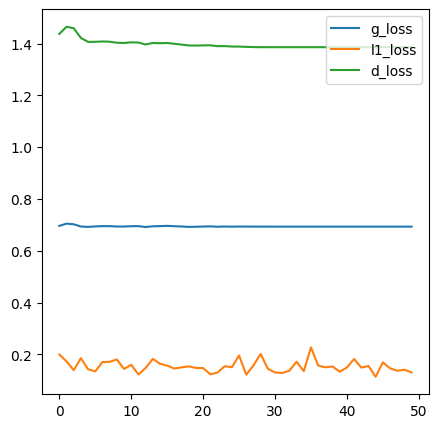

In [20]:
plt.figure(figsize=(5, 5))
plt.plot(g_losses, label='g_loss')
plt.plot(l1_losses, label='l1_loss')
plt.plot(d_losses, label='d_loss')
plt.legend()
plt.show()

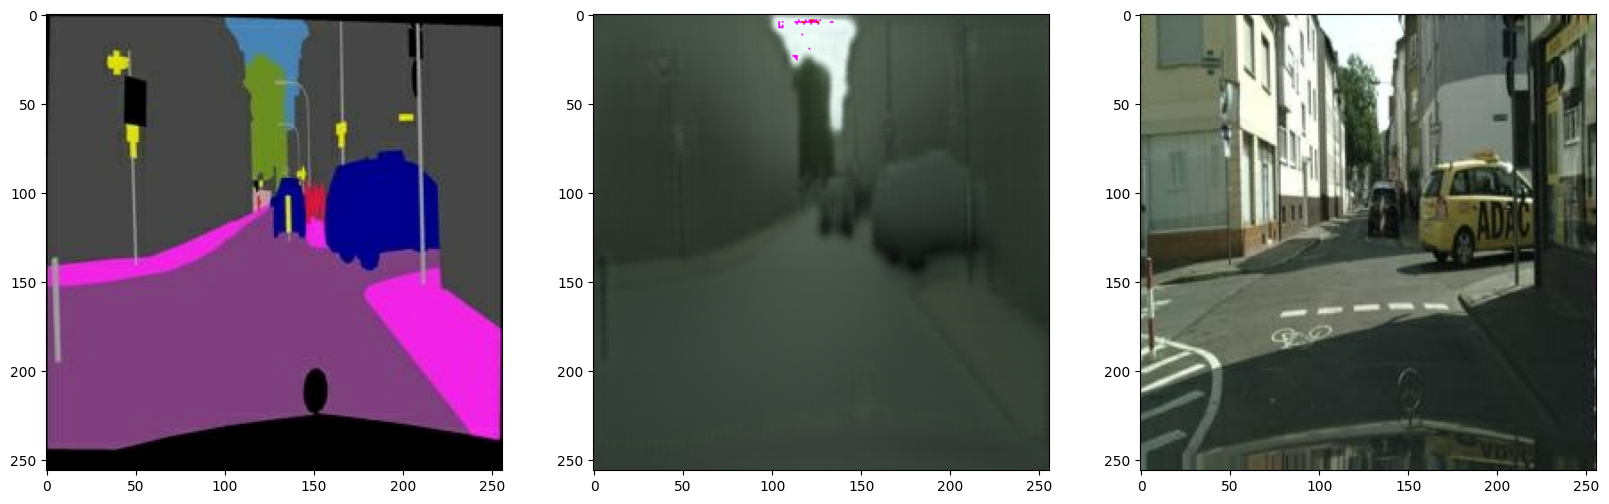

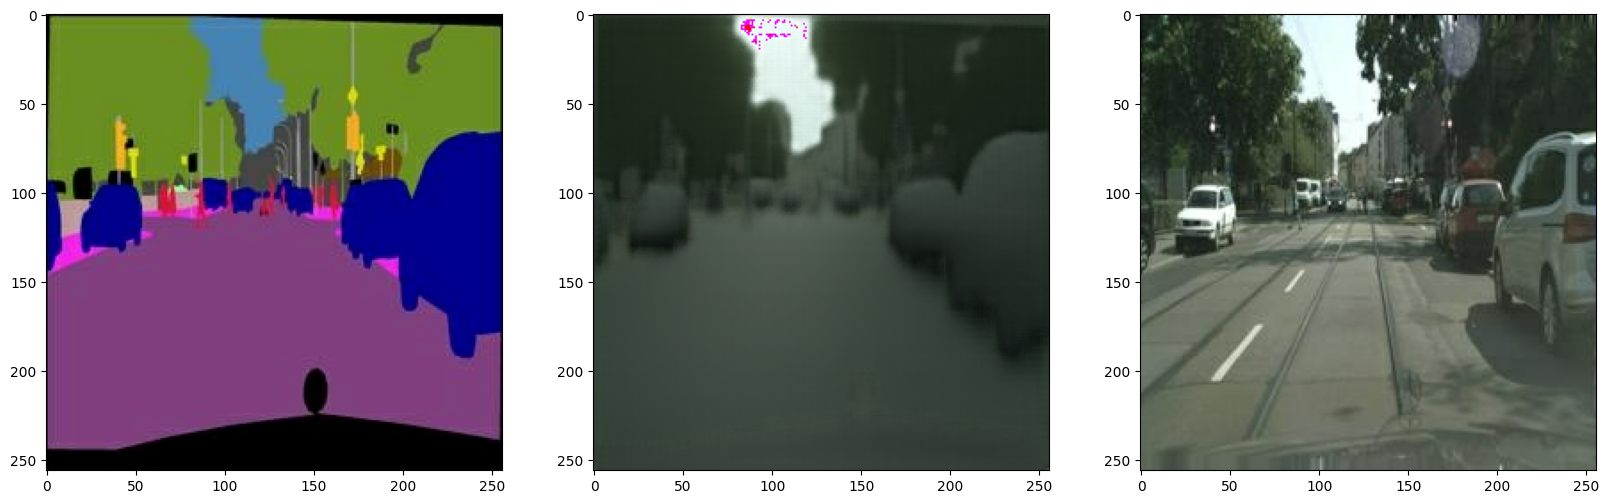

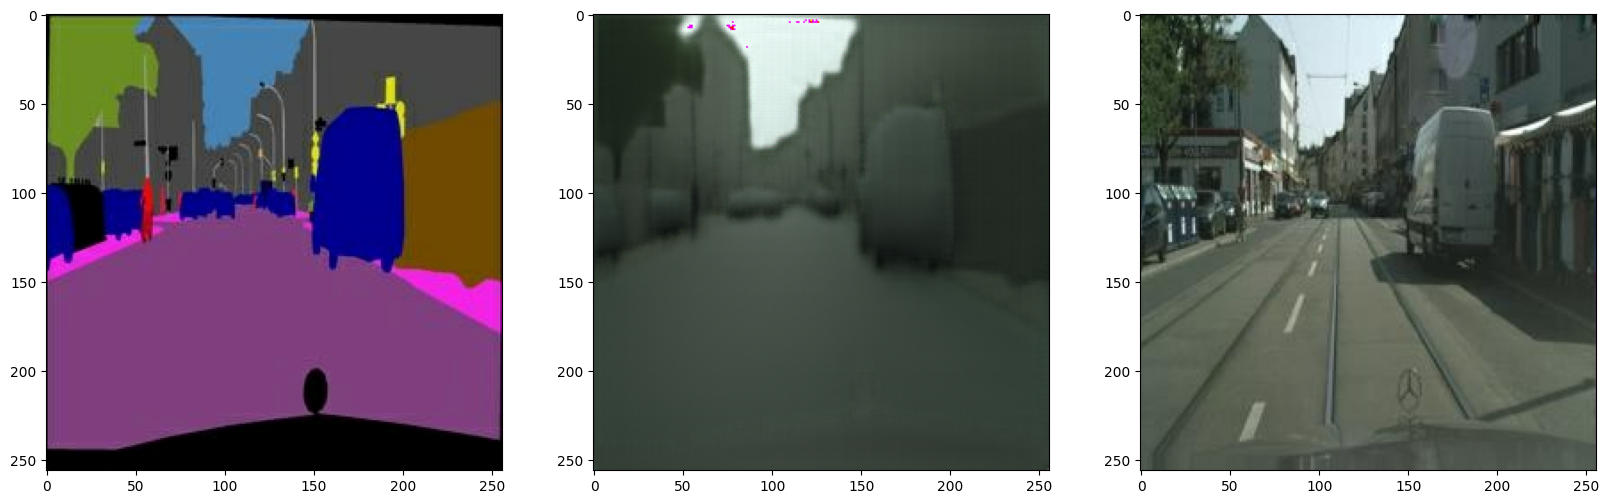

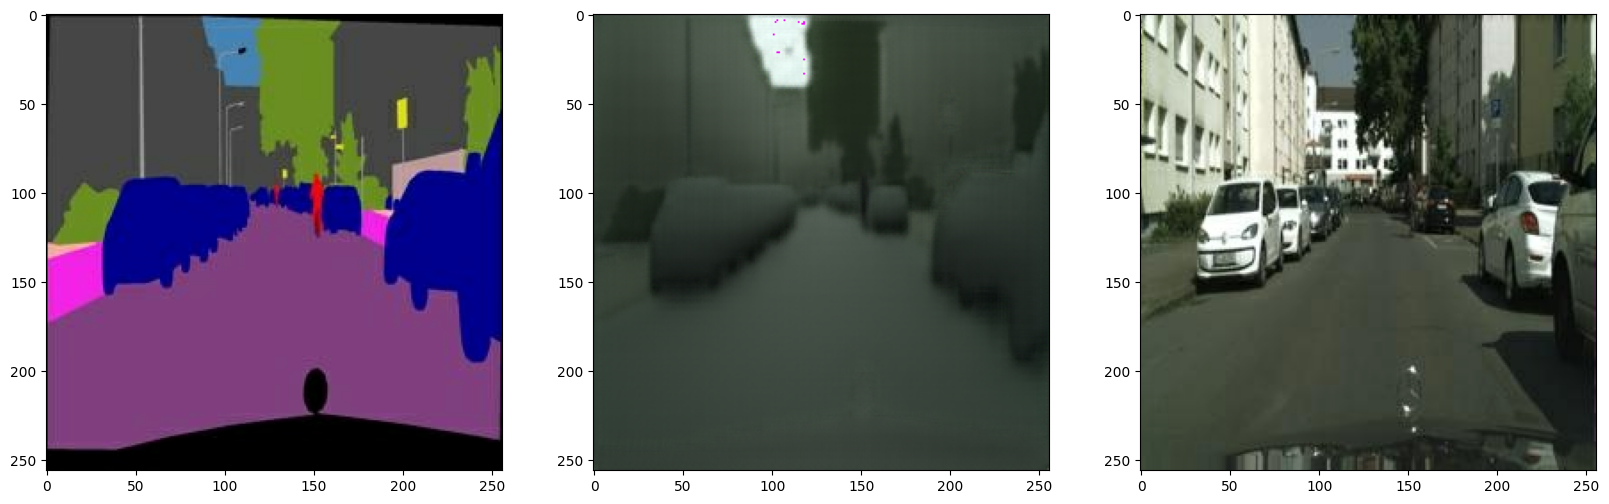

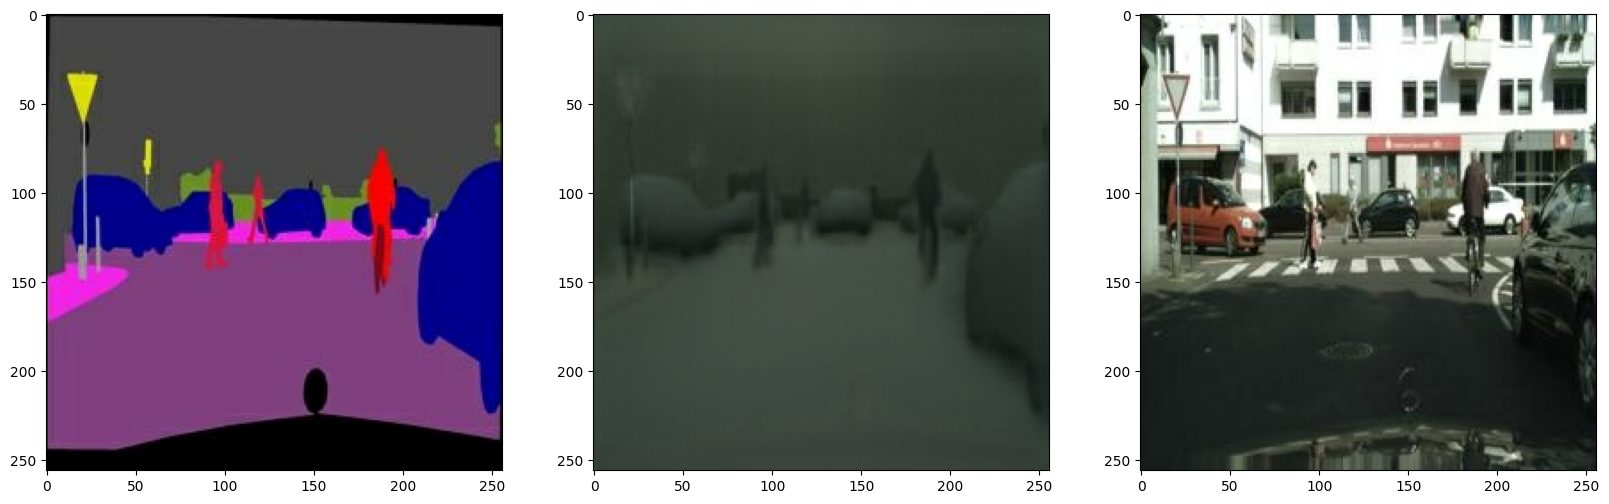

In [21]:
# test data로 학습된 Generator 테스트
def get_test_data(img_path):
    fake, real = load(img_path)
    return fake, real

test_data_path = '/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/segmentation_map/cityscapes/val/'
test_images = data.Dataset.list_files(test_data_path + '*.jpg')
test_images = test_images.map(get_test_data)

for i, (fake, real) in enumerate(test_images):
    pred = generator(tf.expand_dims(fake, 0))
    pred = denormalize(pred)
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1); plt.imshow(denormalize(fake))
    plt.subplot(1, 3, 2); plt.imshow(pred[0])
    plt.subplot(1, 3, 3); plt.imshow(denormalize(real))

---

### **고찰**

#### 1. **데이터 전처리**  
- 기존에 손에 익었던 list 형식으로 하려고 했으나 type오류가 생겨 BatchDataset으로의 변환이 필요했다.  
전처리 때마다 느끼지만 입력 데이터 형식을 잘 맞춰주는 것이 중요하다.

In [22]:
type(train_images)

tensorflow.python.data.ops.dataset_ops.BatchDataset

#### 2. **모델 학습**


- 확연하게 좋은 한 지점이 있지는 않았으며 Generator_loss는 epoch==5에서, L1_loss는 epoch==45에서 최저값을 보였고,  
Discriminator_loss가 epoch 30 이후에 일정했다는 특이점을 볼 수 있었다.

---


### **참고문헌**

Isola, Phillip, et al. "Image-to-image translation with conditional adversarial networks." *Proceedings of the IEEE conference on computer vision and pattern recognition.* 2017.

https://www.tensorflow.org/guide/data